# Python Laboratory for Dislocation Dynamics (pyLabDD)

Simple 2D dislocation dynamics demonstration to calculate stress fields of dislocations, their self-interactions via Peach-Koehler forces and to relax a random dislocation configuration and then do a dynamic shear test. Methods for graphical output of stress fields are also provided. 

Author: Alexander Hartmaier</br>
Institute: ICAMS / Ruhr-universität Bochum</br>
Date: December 2021

This work is licensed under a Creative 
Commons Attribution-NonCommercial-ShareAlike 4.0 International License
<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">(CC-BY-NC-SA)</a>
 <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">
<img alt="Creative Commons License" style="border-width:0;max-heigt:9px;height:100%;" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a>

Uses the libraries numpy (http://www.numpy.org/) and matplotlib (https://matplotlib.org/).



## 1 Dislocations and stress fields

Provide functions to evaluate stress fields of edge dislocations according to

\begin{equation}
\sigma_{xx} = -\frac{\mu b_x}{2\pi (1-\nu)} \frac{y \left( 3x^2 + y^2 \right)}{\left(x^2 + y^2 \right)^2}
\end{equation}

\begin{equation}
\sigma_{yy} = \frac{\mu b_x}{2\pi (1-\nu)} \frac{y \left(x^2 - y^2 \right)}{\left(x^2 + y^2 \right)^2}
\end{equation}

\begin{equation}
\sigma_{xy} = \frac{\mu b_x}{2\pi (1-\nu)} \frac{x \left(x^2 - y^2 \right)}{\left(x^2 + y^2 \right)^2}
\end{equation}

Note that for the contributions of $b_y$ components of the Burgers vectors, $x$ and $y$ need to be exchanged in all above equations.

### 1.1 Plot stress fields of dislocations

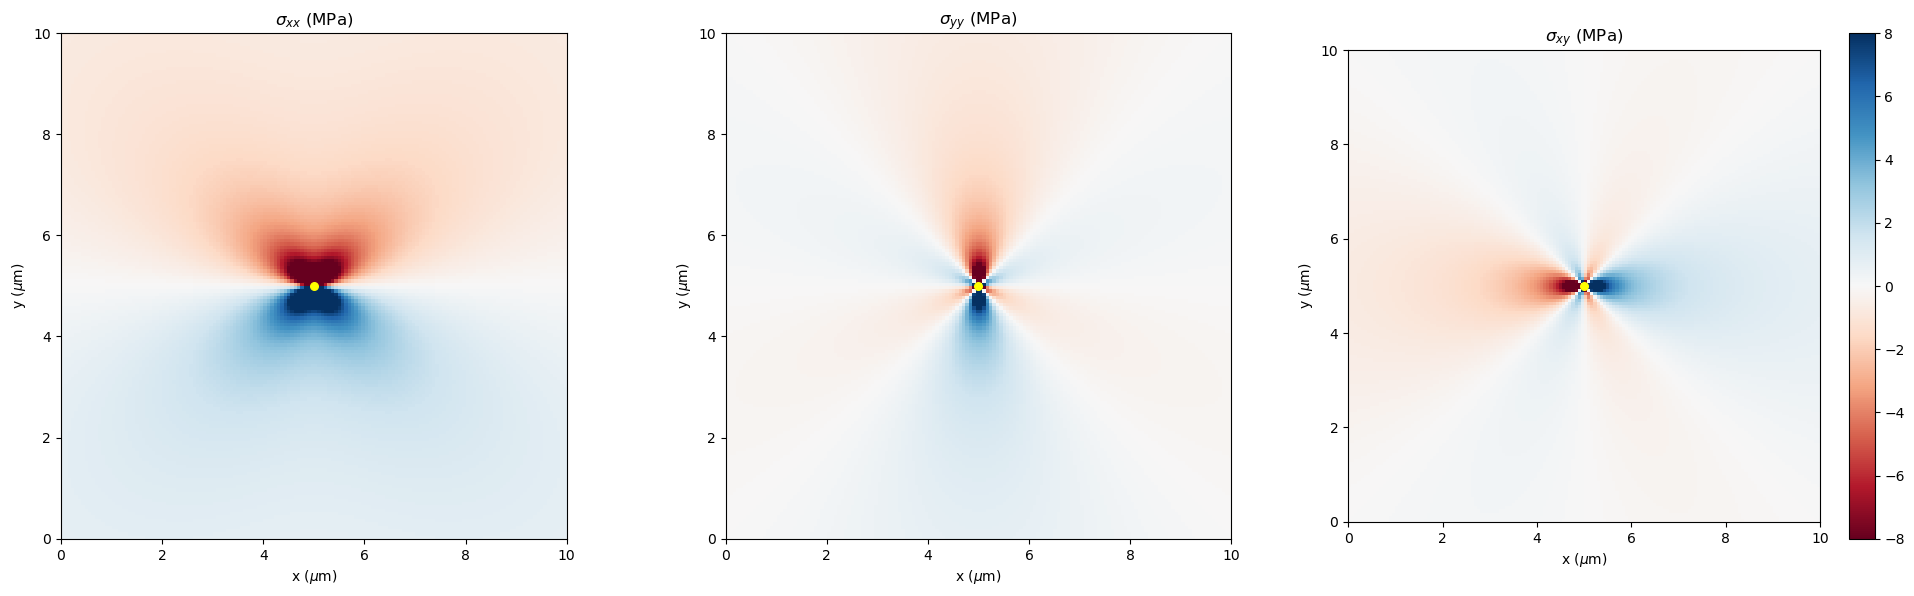

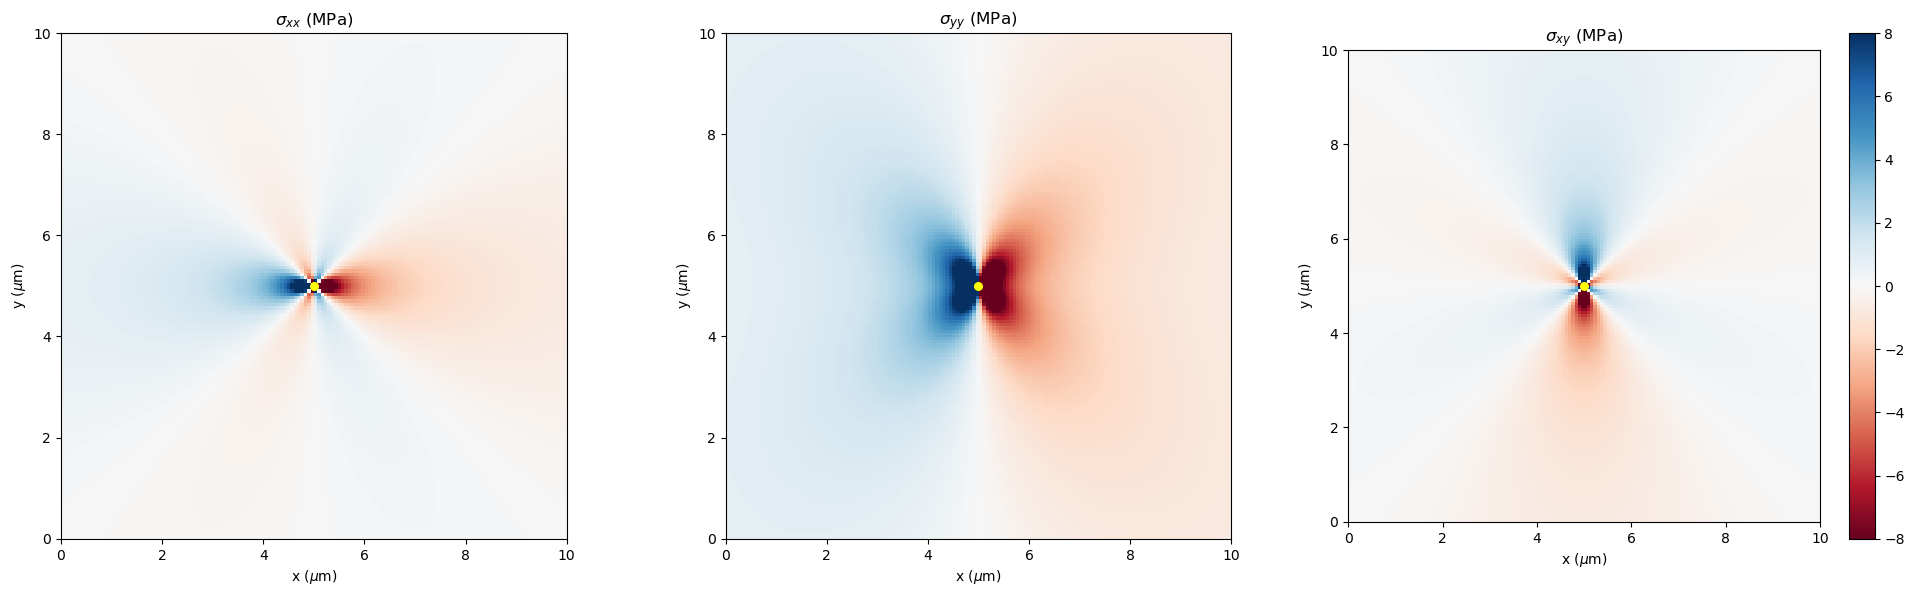

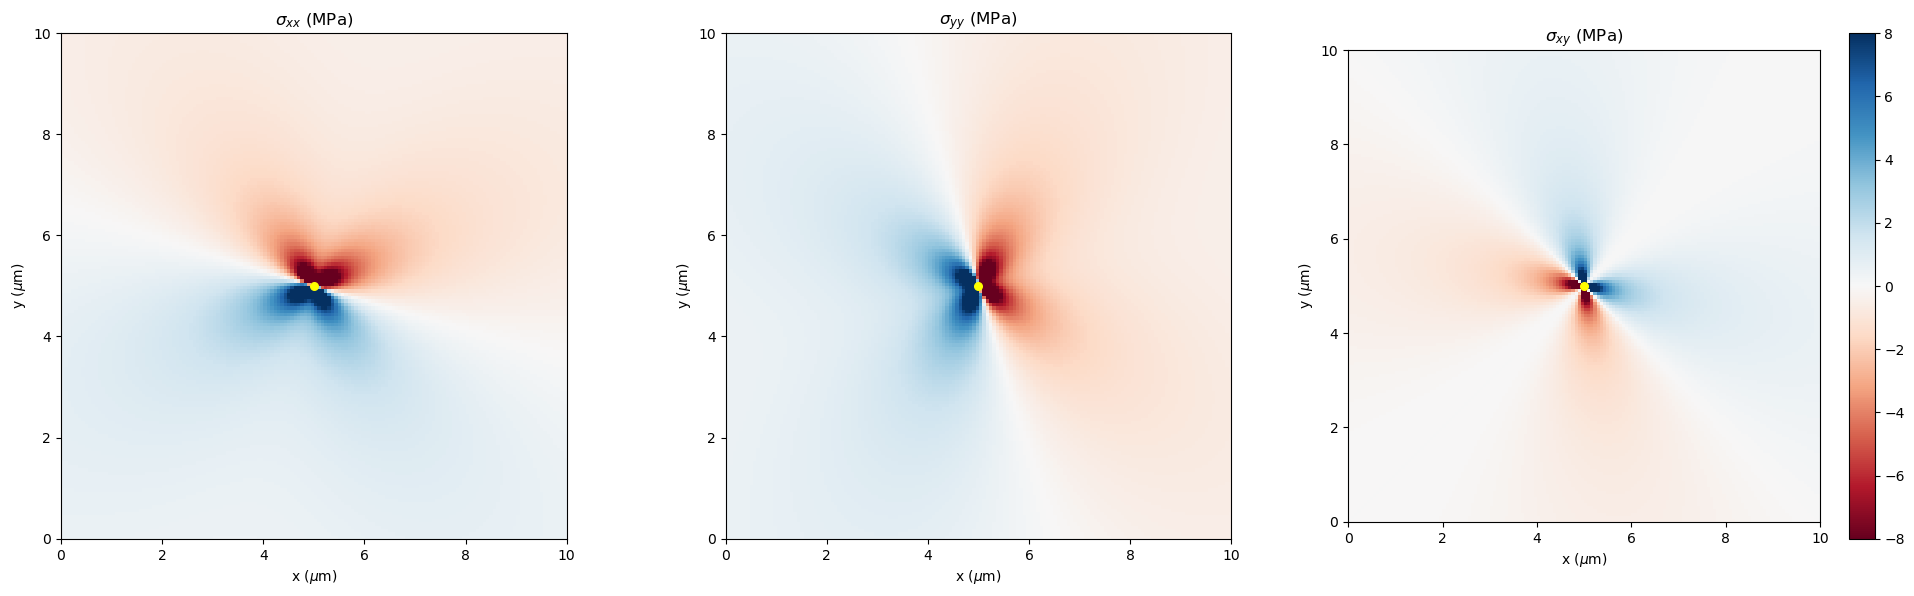

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylabdd as dd

#define material parameters
#units: stress: MPa; length: micrometers; time: microseconds
#define material parameters
#units: stress: MPa; length: micron; time: microseconds
mu = 80.0e3          # shear modulus
nu = 0.3             # Poisson ratio
b0 = 0.2e-3          # Burgers vector norm
C = mu*b0/(2*np.pi*(1.-nu))   # Constant for dislocation stress field
f0 = 10.             # initial slip resistance

#define box 
LX = LY = 10.

#define different dislocations in box
dsl10 = dd.Dislocations(1, 0, 0., C, b0, xpos=LX/2, ypos=LY/2, LX=LX, LY=LY)  # initialze object of class Dislocations
dsl10.plot_stress()             # plot elastic fields

dsl01 = dd.Dislocations(1, 0, 90.*np.pi/180., C, b0, xpos=LX/2, ypos=LY/2, LX=LX, LY=LY)  # initialze object of class Dislocations
dsl01.plot_stress()             # plot elastic fields

dsl11 = dd.Dislocations(1, 0, 45.*np.pi/180., C, b0, xpos=LX/2, ypos=LY/2, LX=LX, LY=LY)  # initialze object of class Dislocations
dsl11.plot_stress()             # plot elastic fields


## 2 Peach-Koehler force
Dislocations interact with each other via their elastic fields. The driving force for dislocation motion is the Peach-Koehler force, which is defined as

\begin{equation}
F_{PK} = \left( \sigma \cdot b \right) \times l
\end{equation}

For 2D, plane stress conditions, $\sigma={\sigma_{11} \sigma_{12} \choose \sigma_{12} \sigma_{22} }$, $b= {b_x \choose b_y}$, and $l_x = l_y =0, l_z = 1$, such that

\begin{equation} 
F_{PK} = {\sigma_{12} b_x+\sigma_{22} b_y \choose \sigma_{11} b_x+\sigma_{12} b_y}. 
\end{equation}


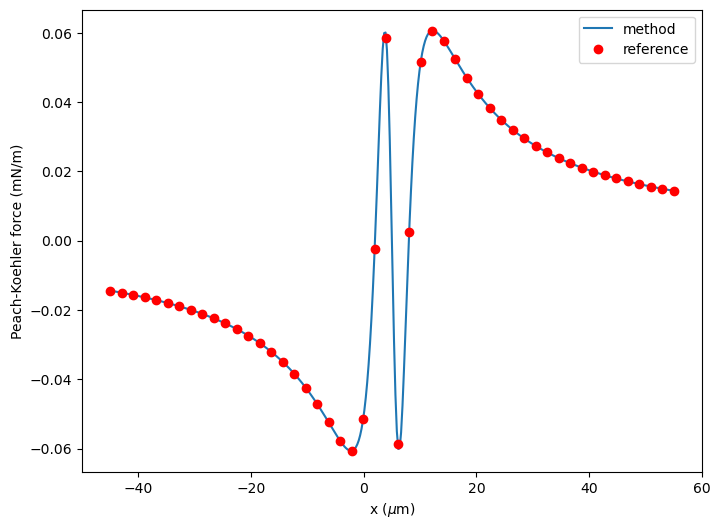

In [2]:
#calculate and plot reference solution for Peach-Koehler force
dist_y = 3
fpk, xp = dsl10.calc_PKforce(dist_y+dsl10.ypos[0], ngp=400, x1=-45., x2=55)
fig = plt.figure(figsize=(8,6))
plt.plot(xp,fpk,label='method')

#setup positions where reference solution is evaluated
dx = np.linspace(-45,55,num=50) - dsl10.xpos
dy = np.ones(50)*dist_y
b0 = dsl10.b0
fpk = dsl10.C*b0*1000*(dx*(dx*dx-dy*dy))/(dx*dx+dy*dy)**2  # analytical equation for PK force, units: mN/m

#alternative solution based on stress field in Dislocation object
#sxy = dsl1.sig_xy(dx, dy)
#fpk = sxy*b0

#plot solution as red circles over reference curve
plt.plot(dx+dsl10.xpos,fpk,'or',label='reference')

plt.xlabel(r'x ($\mu$m)')
plt.ylabel('Peach-Koehler force (mN/m)')
plt.legend()
plt.show()

In the next step, the PK force caused by a group of dislocations is analysed. Not the difference in the magnitude of maxima and minima in the force.

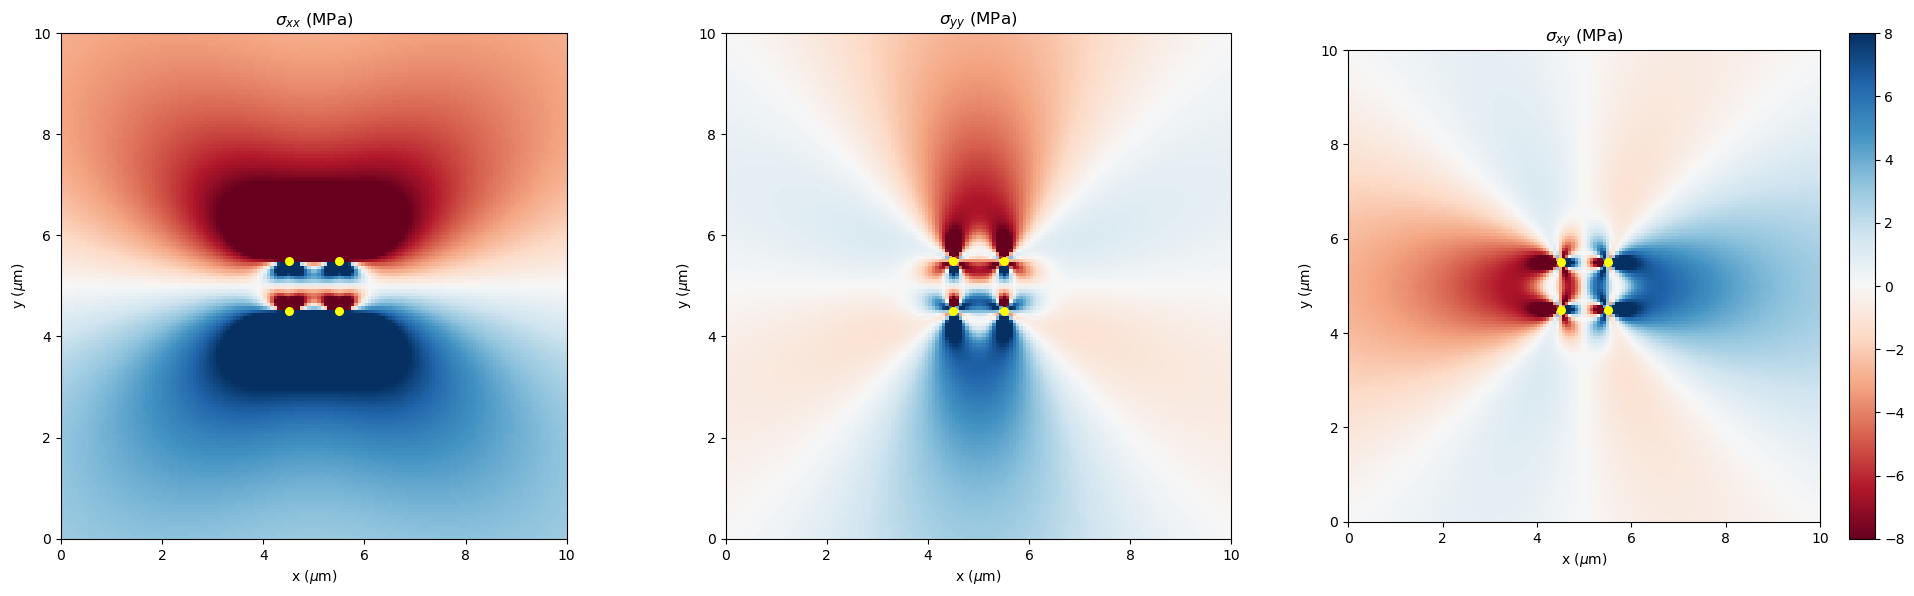

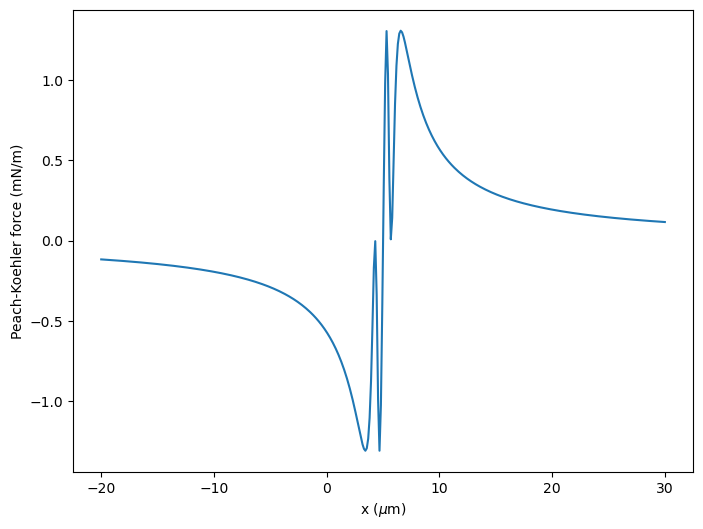

Distance between dislocations (micrometer): 1.0
Max. Peach-Koehler force (mN/m): 1.3070403191836706


In [3]:
# define box with 4 dislocations
LX = LY = 10.
d=LY*0.1     # distance between dislocations
x0 = 0.5*(LX - d)    # position of first dislocation
y0 = 0.5*(LY - d)
xpos = [x0, x0+d, x0, x0+d]
ypos = [y0, y0+d, y0+d, y0]
dsl4 = dd.Dislocations(4, 0, 0., C, b0, xpos=xpos, ypos=ypos, LX=LX, LY=LY)
dsl4.plot_stress()

#calculate PK force along central line through the box
fpk, xp = dsl4.calc_PKforce(LY/2, ngp=400, x1=-20.01, x2=30)
fig = plt.figure(figsize=(8,6))
plt.plot(xp,fpk)
plt.xlabel(r'x ($\mu$m)')
plt.ylabel('Peach-Koehler force (mN/m)')
plt.show()
print('Distance between dislocations (micrometer):', d)
print('Max. Peach-Koehler force (mN/m):', np.max(fpk))

## 3 Dislocation dynamics
Setup dislocation distribution via pyLabDD class 'Dislocations' in which all necessary variables and functions are defined and initialized.

### 3.1 Initialize dislocation configuration

Define material properties, simulation box and numerical parameters, total number of dislocation, number of mobile dislocations, number and inclination angle of slip planes.

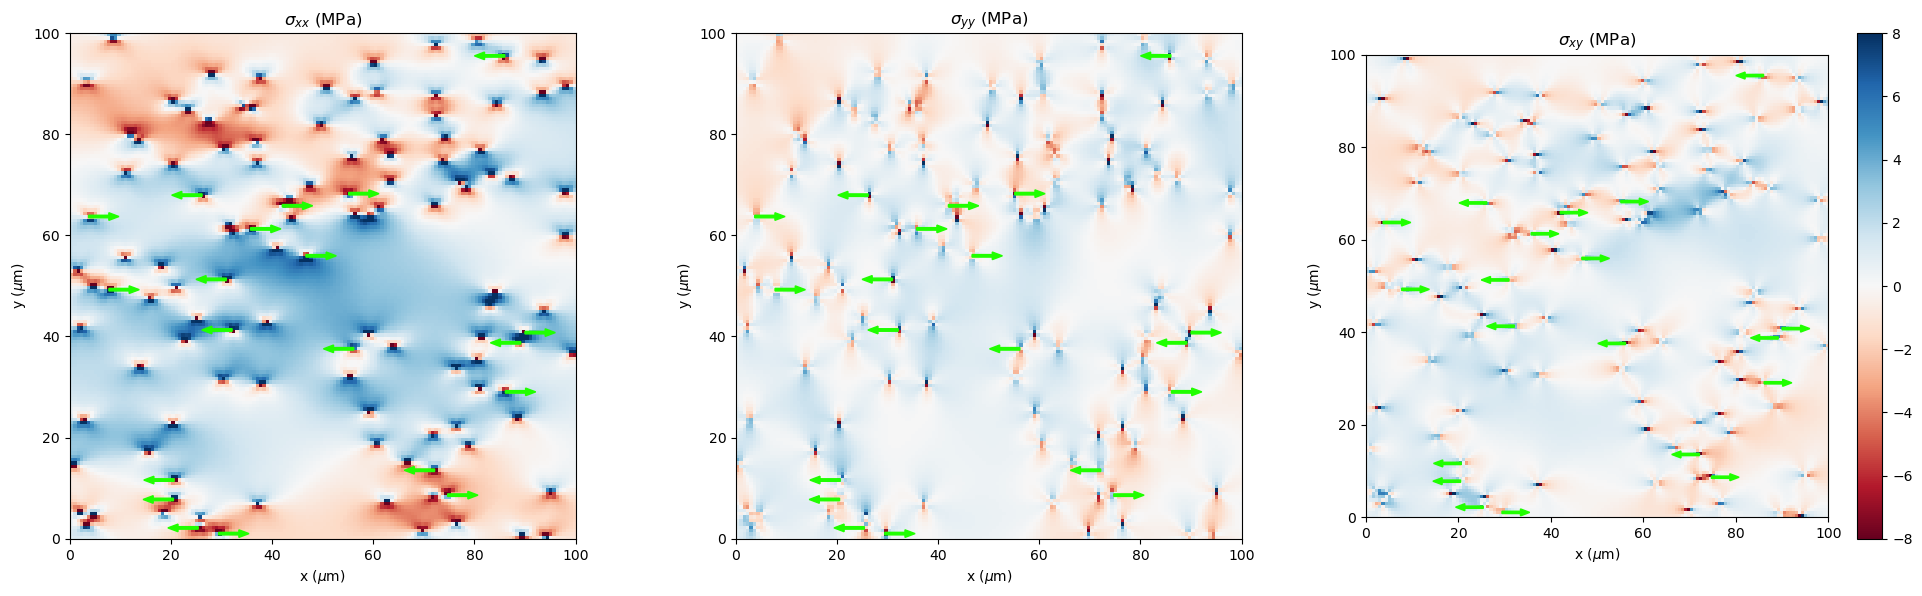

Initial configuration, Ntot: 120  Nmob:  20
box size: 100.0 micron x  100.0 micron
total dislocation density:  0.012 /micron^2
mobile dislocation density:  0.002 /micron^2


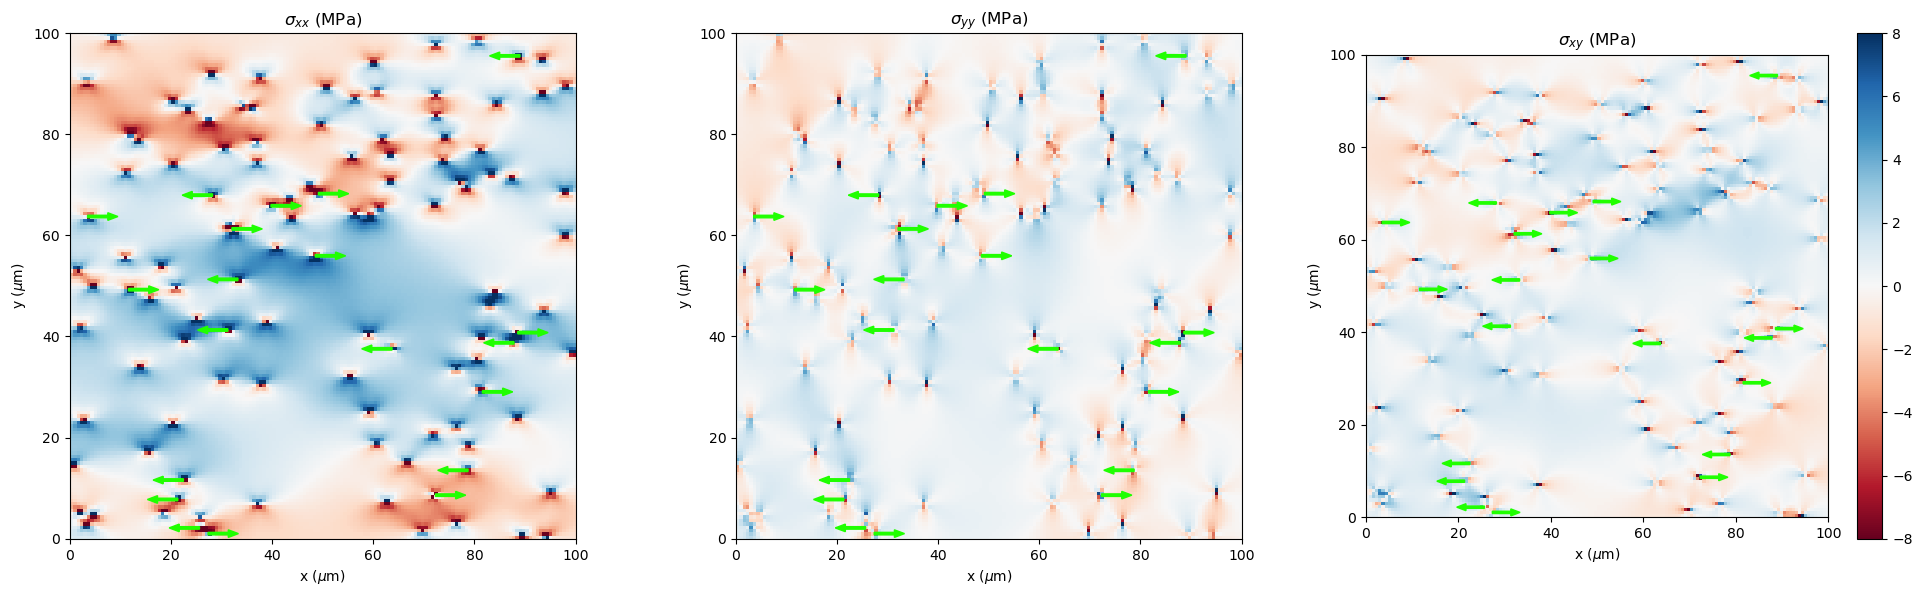

Iteration: 5000 , residual force: 0.14489690373113187


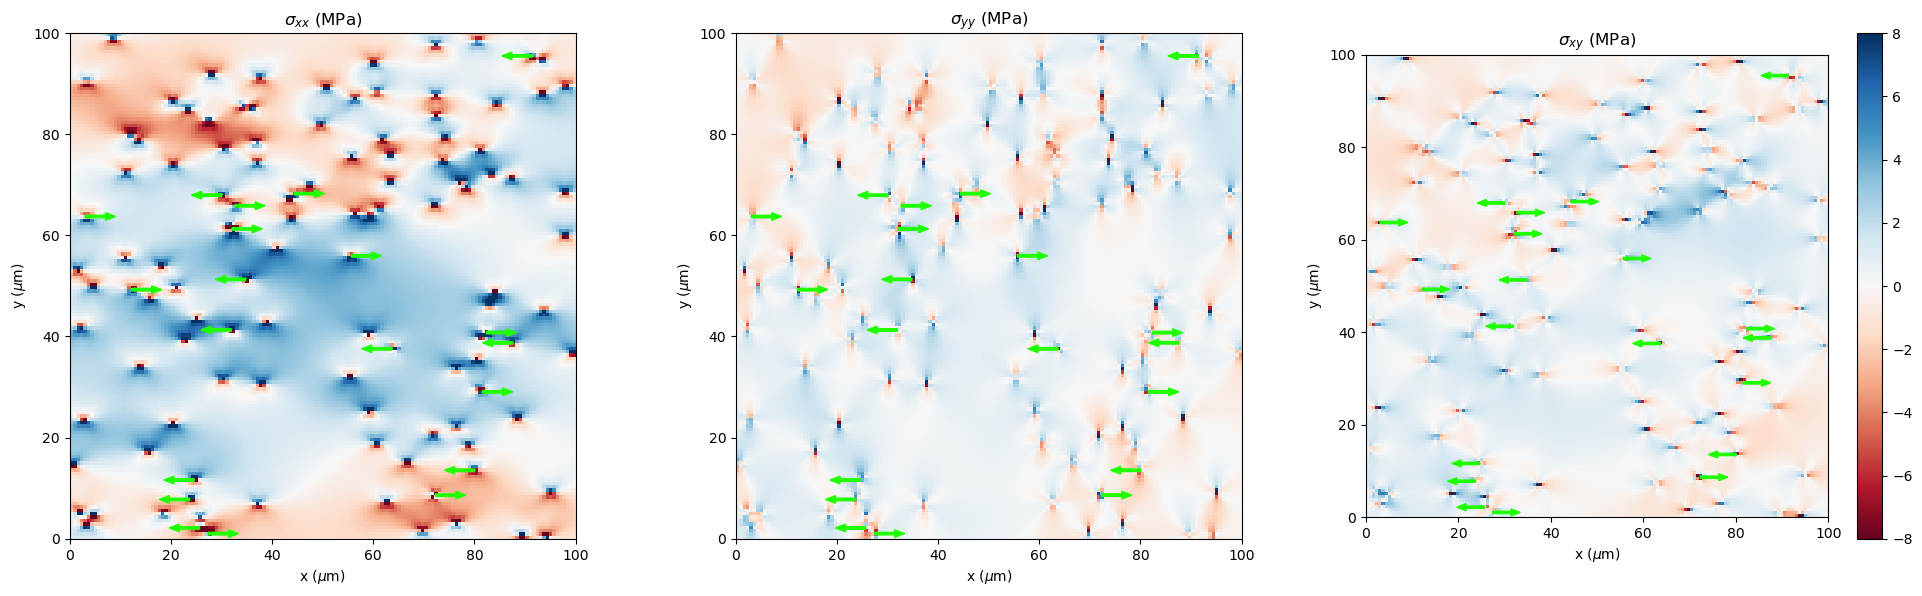

Iteration: 10000 , residual force: 0.09271579405690558


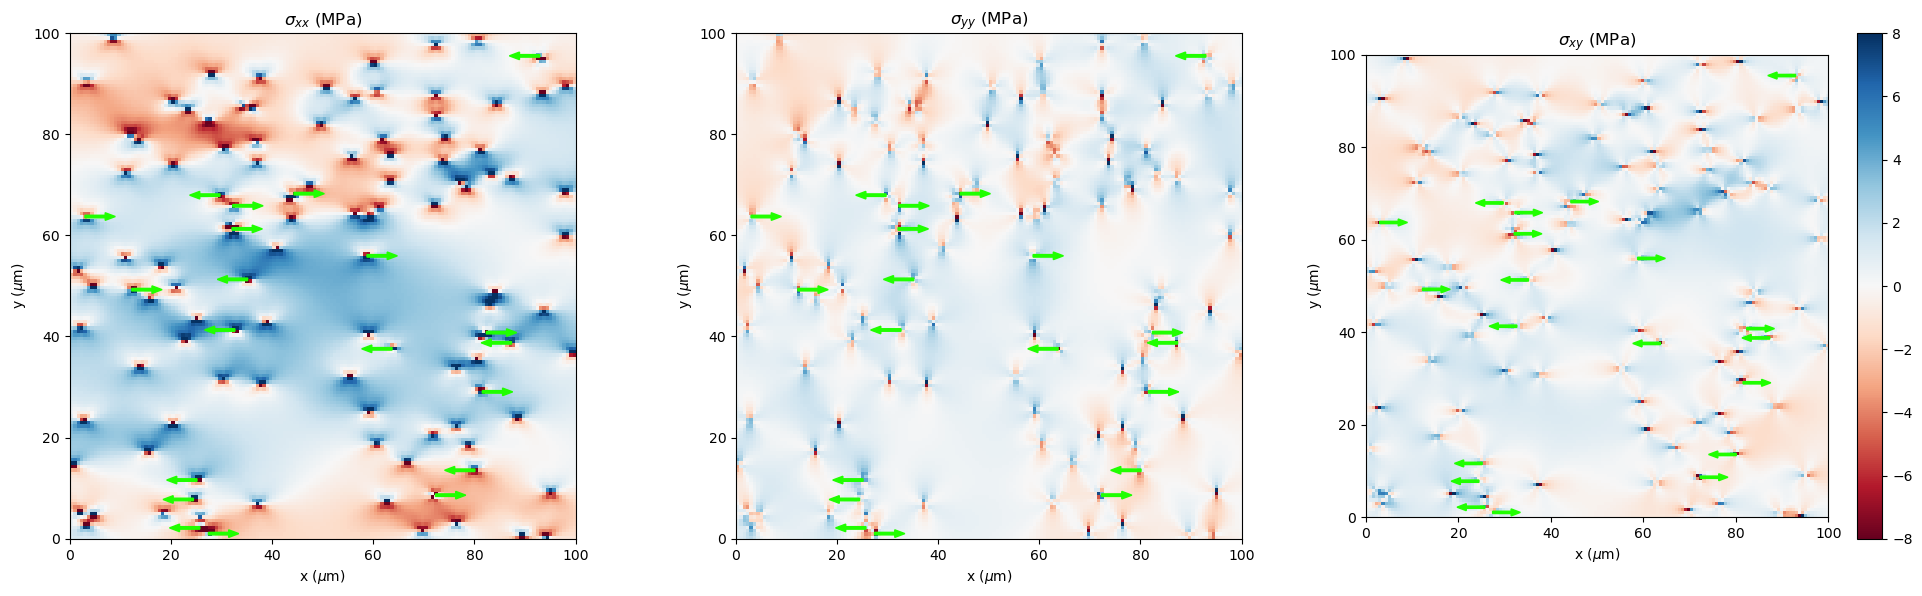

Final configuration 11606 0.049992733084983074


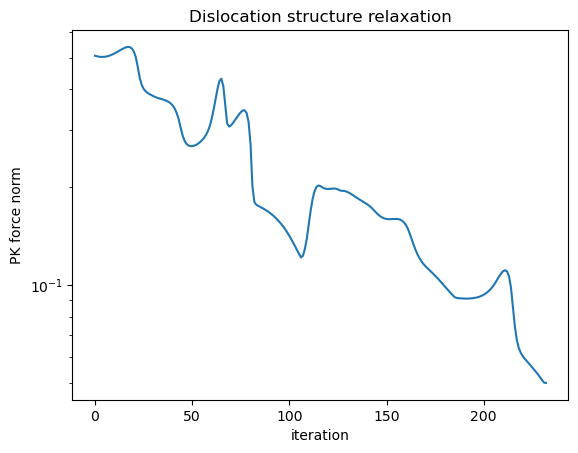

In [4]:
#box geometry
LX = 100.             # box dimension in x-direction
LY = 100.             # box dimension in y-direction
bc = 'pbc'            # set boundary conditions: 'fixed' or 'pbc'

#define numerical parameters
dt0 = 0.02           # time step
np.random.seed(110)  # seed RNG

#define dislocations
Ntot = 120 # total number of dislocations
Nmob = 20  # number of mobile dislocations
dsl = dd.Dislocations(Ntot, Nmob, 0., C, b0, LX=LX, LY=LY, bc=bc, f0=f0) 
dsl.positions()   # initialize positions randomly
dsl.plot_stress() # plot initial configuration
print('Initial configuration, Ntot:',dsl.Ntot,' Nmob: ',dsl.Nmob)
print('box size:',LX,'micron x ',LY,'micron')
print('total dislocation density: ',dsl.rho,'/micron^2')
print('mobile dislocation density: ',dsl.rho_m,'/micron^2')

#relax dislocation configuration, i.e. move dislocations to force equilibrium
dsl.relax_disl(plot_conf=True)


### 3.2 Dynamical virtual shear testing

Virtual dynamic tensile test with loading rate  1.0 /s
Performing 100000 iterations with initial time step 0.005


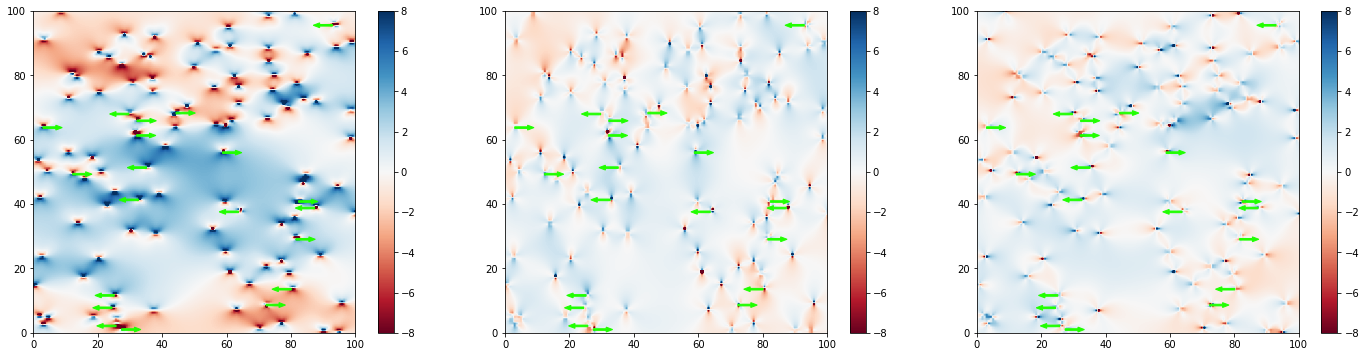

Start configuration:  120  dislocations, boxsize =  100.0 x 100.0 micron^2


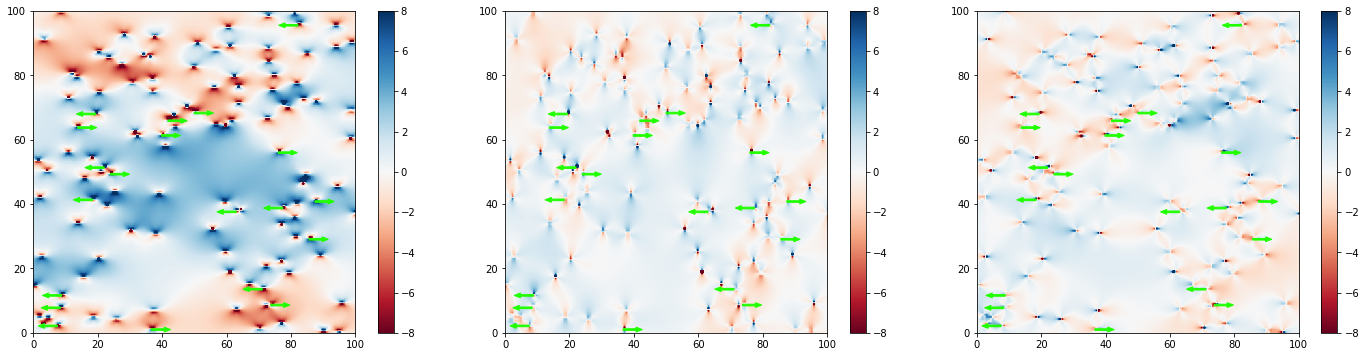

Configuration at sig =  4.385423597316608  epl =  8.047099279894405e-05  in iteration  10000 | Time step:  0.007


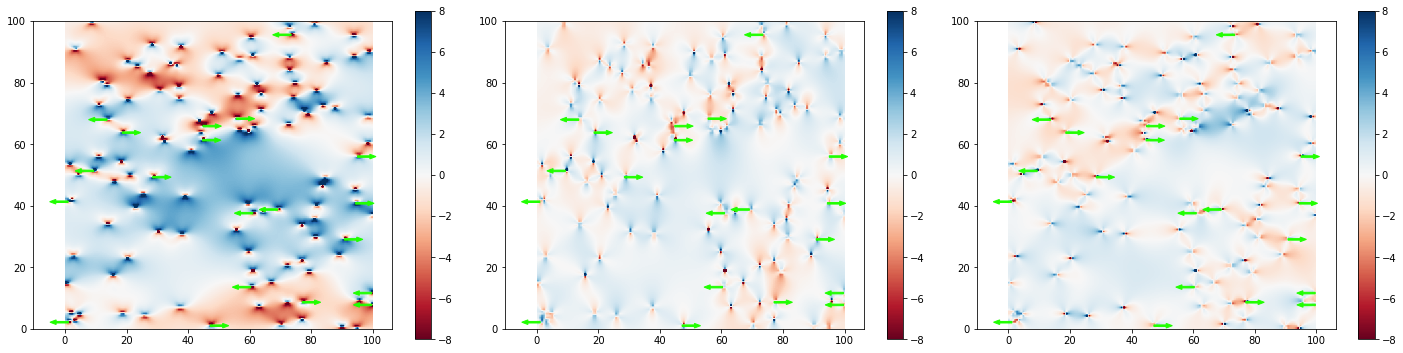

Configuration at sig =  4.264847536585249  epl =  0.00014360248285814957  in iteration  20000 | Time step:  0.00747


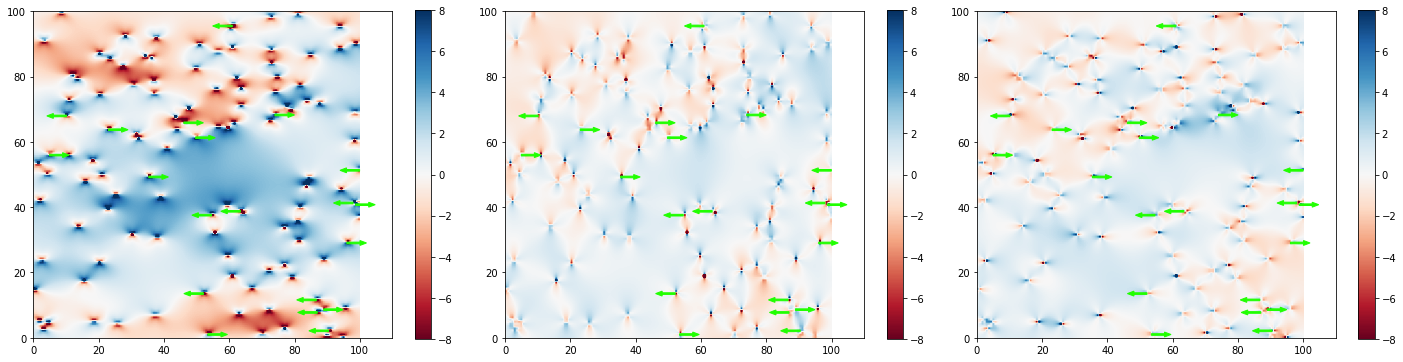

Configuration at sig =  4.135568813791986  epl =  0.00020715675401466695  in iteration  30000 | Time step:  0.00393


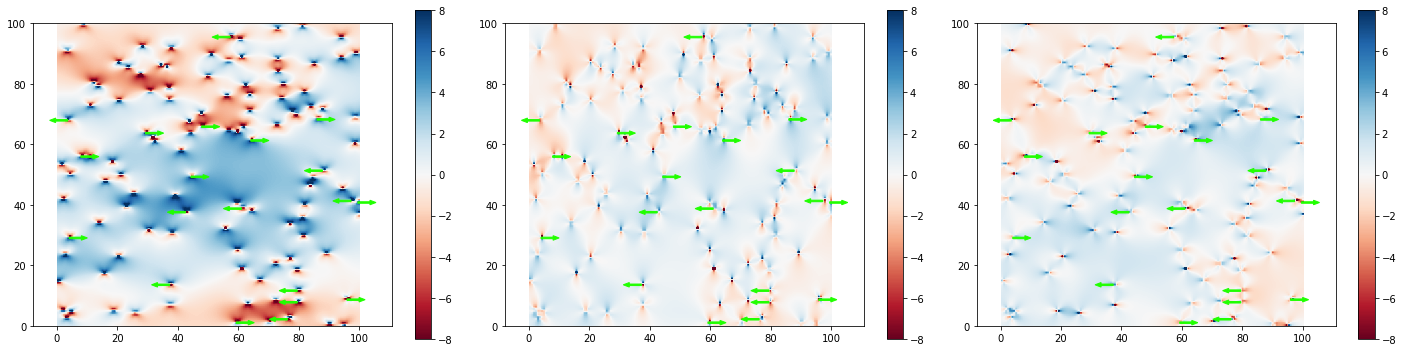

Configuration at sig =  4.272721417386402  epl =  0.000266794032881704  in iteration  40000 | Time step:  0.00567


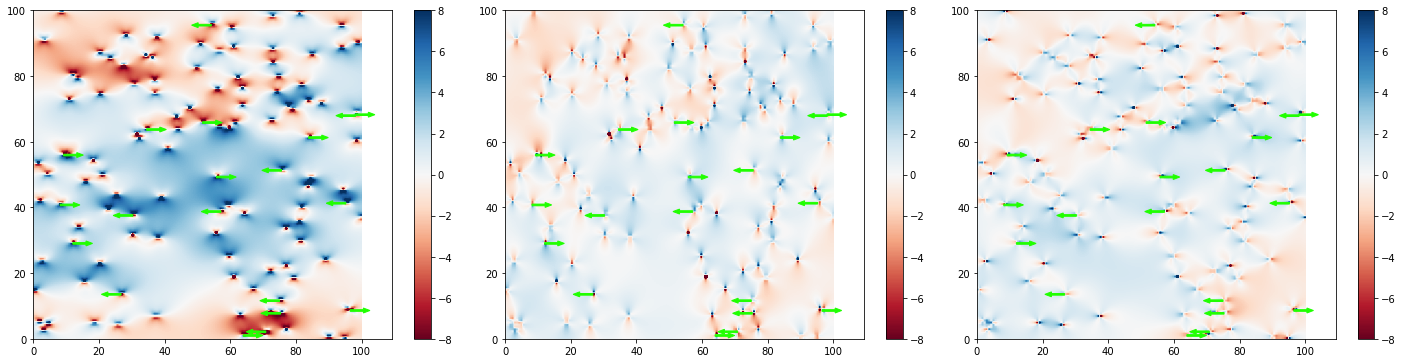

Configuration at sig =  4.362370679399826  epl =  0.000322344984109574  in iteration  50000 | Time step:  0.00567


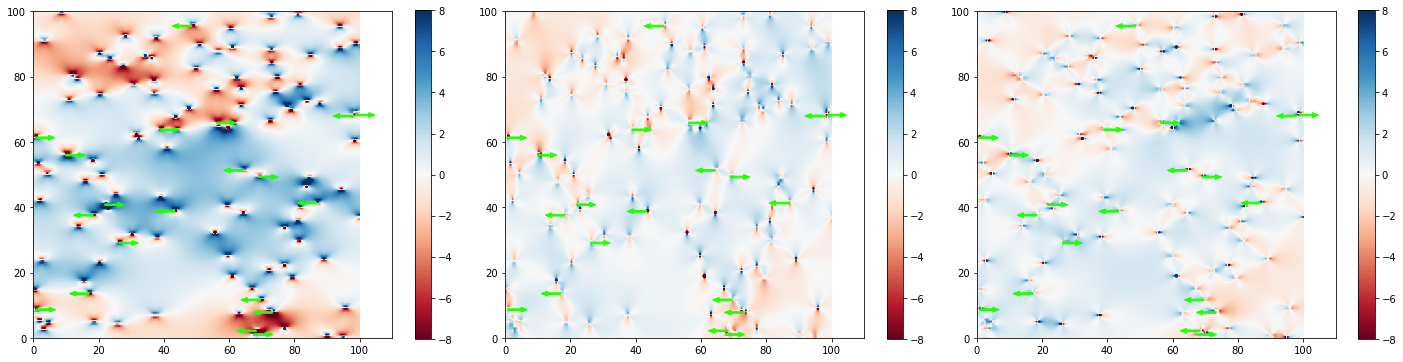

Configuration at sig =  4.420017995232038  epl =  0.0003812615748122749  in iteration  60000 | Time step:  0.0055
Number of iterations performed:  69669 | total strain achived:  0.0005000056452961495
Time step in last iteration:  0.007319069380940509


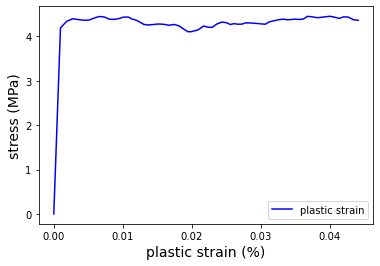

In [3]:
moblaw = 'powerlaw'   # set mobility law used for dislocation motion: 'viscous' or 'powerlaw'

#set strain parameters
edot = 1.e-6  # strain rate (per microsecond), vary between 1.e-8 and 1.e-5
efin = 0.0005   # final strain
nstep = 100000  # max number of steps (int(efin/(edot*dt*100.))*1000 )
idat = int(nstep/100) # frequency of data storage
ipl  = 10*idat # frequency of plotting
dt0 = 5.e-9/edot  #0.03    # values up to 0.05 yield similar results
dt = dt0

print('Virtual dynamic tensile test with loading rate ',edot*1e6,'/s')
print('Performing',nstep,'iterations with initial time step', dt0)
#initialize variables
tau0 = 0.     # macro shear stress
epl  = 0.     # plastic strain
etot = 0.     # total strain
sig_m = [0.]   # initialize list for stress values for postprocessing 
epl_m = [0.]
eps_m = [0.]
ic = 0
Nm = dsl.Nmob
Cpl = dsl.rho_m*b0  # prefactor for Orowan law

dsl.plot_stress()
print('Start configuration: ', dsl.Ntot, ' dislocations, boxsize = ',LX,'x',LY,'micron^2')

while etot<efin and ic<nstep:
    etot +=edot*dt
    tau0 = mu*(etot-epl)
    fsp, dt = dsl.move_disl(tau0, Nm, moblaw, dt)
    #calculate plastic slip
    dgpl = Cpl*(np.dot(dsl.dx,dsl.bx) + np.dot(dsl.dy,dsl.by))
    epl += dgpl
    if epl>etot:
        print('Warning: check time step', ic, nit, dgpl, tau0, epl, etot, fn)
    ic += 1
    if ic%idat==0:
        sig_m.append(tau0)
        eps_m.append(etot)
        epl_m.append(epl)
        if ic%ipl==0:
            dsl.plot_stress()
            print('Configuration at sig = ', tau0,' epl = ',epl,' in iteration ',ic,'| Time step: ',dt.round(5))

print('Number of iterations performed: ',ic,'| total strain achived: ',etot)
print('Time step in last iteration: ',dt)

epl_m = np.array(epl_m)
sig_m = np.array(sig_m)
eps_m = np.array(eps_m)
plt.plot(epl_m*100,sig_m,'b')
plt.xlabel('plastic strain (%)',fontsize=14)
plt.ylabel('stress (MPa)',fontsize=14)
plt.show()